In [1]:
'import libraries of interest'
from spectral.io import envi
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity as cosineDist
from scipy.io import savemat

from ganTraining import GANModel_1d 
from matplotlib import pyplot as plt

%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
'------------------------------------------------------------------------------------------------------'
'STEP-1: CREATE A NEURAL NETWORK MODEL FOR THE REPRESENTATION'
'------------------------------------------------------------------------------------------------------'
obj = GANModel_1d(img_rows=240, dropout=0.0, genFilters=250, disFilters=20, filterSize=11)
dis1 = obj.disModel_CV_L6s2()
'Get the pre-trained weights'
dis1.load_weights(('/Volume2/arunFiles/pythonCodeFiles/CRISM_repLearning/modelsOnYukiModel_cR_wGAN' +
                   '/Models/Model-4_small/discriminator/dis_cR_75.h5'))
disRep = obj.disModel_CV_L6s2_rep(dis1)
disRep.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 120, 20)           240       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 40)            8840      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 30, 80)            35280     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 15, 160)           140960    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2400)              0         
Total params: 185,320
Trainable params: 185,320
Non-trainable params: 0
_________________________________________________________________


In [3]:
'------------------------------------------------------------------------------------------------------'
'STEP-2: LOAD AND NORMALIZE MICA CONTINUUM REMOVED DATA'
'------------------------------------------------------------------------------------------------------'
sliName = '/Volume1/data/CRISM/arun/UMass_redMICA_CR_enhanced_v4.sli'
sliHdrName = '/Volume1/data/CRISM/arun/UMass_redMICA_CR_enhanced_v4.sli.hdr'

'Read in the spectra'
micaSLI = envi.open(sliHdrName, sliName)
mica_dataRed = micaSLI.spectra
mica_dataRed = mica_dataRed[:, 4:244]
mica_dataRed = mica_dataRed.reshape(mica_dataRed.shape[0], mica_dataRed.shape[1], 1)

'Read in the header'
sliHdr = envi.read_envi_header(sliHdrName)
endMem_Name = sliHdr['spectra names']
wavelength = np.asarray(sliHdr['wavelength'], dtype='single')
wavelength = wavelength[4:244]

'Get the predictions at output layer for the MICA DATA'
mica_dataPreds_l2 = np.asarray(disRep.predict(mica_dataRed))

In [4]:
'The test set is'
dataStoreLoc = '/Volume2/arunFiles/pythonCodeFiles/CRISM_repLearning/DataStore/modelsOnYukiModel_cR/store_cR_cS.h5'
with pd.HDFStore(dataStoreLoc, mode='r') as newstore:
    #print newstore.keys()
    df_val = newstore.select('CRISM_cR_samp')

In [5]:
'On this validation set-make predictions'
valSet = np.asarray(df_val)
valSet = valSet.reshape(df_val.shape[0], df_val.shape[1],1)

'Predict activations on validation set'
valSet_Preds = disRep.predict(valSet)

In [6]:
'Find the cosine distance between the exemplars and the data'
dist = np.squeeze(cosineDist(mica_dataPreds_l2, valSet_Preds))

In [7]:
print dist.shape

(27, 1000000)


Text(0.5,1,'Choices 1001-1010 Kaolinite')

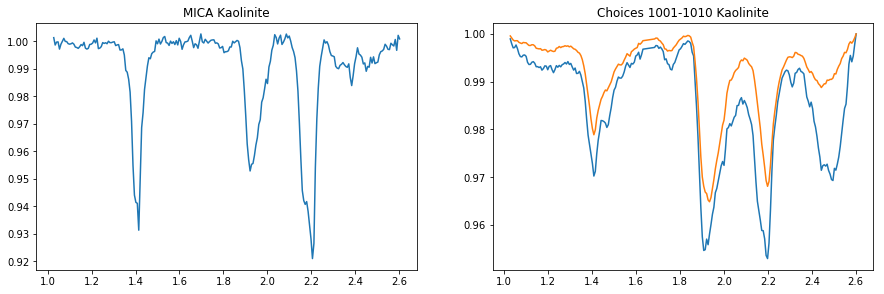

In [8]:
i =9
'Find the ones closest to Kaolinite'
idxSorted_kaol = np.argsort(np.squeeze(1 - dist[i, :])) 

fig1=plt.figure(figsize=(15,10))
ax = plt.subplot(2,2,1)
plt.plot(wavelength, np.squeeze(mica_dataRed[i,:,:]))
plt.title('MICA Kaolinite')

temp = np.squeeze(valSet[idxSorted_kaol[1000:1002],:,:])
ax = plt.subplot(2,2,2)
plt.plot(wavelength, np.squeeze(temp.T))
plt.title('Choices 1001-1010 Kaolinite')

In [9]:
print idxSorted_kaol[1001]

512535


In [10]:
j =10
'Find the ones closest to Kaolinite'
idxSorted_alSmect = np.argsort(np.squeeze(1 - dist[j, :])) 

In [11]:
idx11 = np.asarray(np.where((1 - dist[i, :]) >= (1 - dist[j, :])))
idx21 = np.asarray(np.where((1 - dist[j, :]) <= 0.15))
idx31 = np.asarray(np.where((1 - dist[i, :]) <= 0.15))

idx = np.intersect1d(idx11, idx21)
idx = np.intersect1d(idx, idx31)
print idx.shape

(63,)


256098
0.86755496
0.8985069


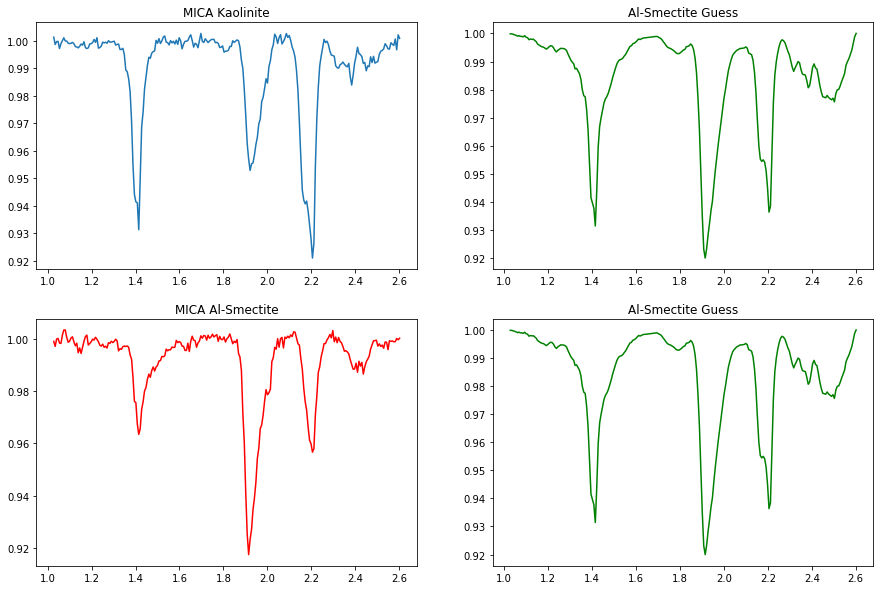

In [12]:
fig1=plt.figure(figsize=(15,10))
ax = plt.subplot(2,2,1)
plt.plot(wavelength, np.squeeze(mica_dataRed[i,:,:]))
plt.title('MICA Kaolinite')
ax = plt.subplot(2,2,3)
plt.plot(wavelength, np.squeeze(mica_dataRed[j,:,:]), 'r-')
plt.title('MICA Al-Smectite')
ii= 17
print idx[ii]

temp = np.squeeze(valSet[idx[ii],:,:])
ax = plt.subplot(2,2,2)
plt.plot(wavelength, np.squeeze(temp.T), 'g-')
plt.title('Al-Smectite Guess')
ax = plt.subplot(2,2,4)
plt.plot(wavelength, np.squeeze(temp.T), 'g-')
plt.title('Al-Smectite Guess')
print dist[i, idx[ii]]
print dist[j, idx[ii]]

In [17]:
savemat('identGuess_diff.mat', {
    'Mica_Kaolinite' : np.squeeze(mica_dataRed[i,:,:]), 
    'Mica_AlSmect' : np.squeeze(mica_dataRed[j,:,:]), 
    'ChosenPix' : np.squeeze(temp.T),
    'wavelength' : wavelength
})

In [ ]:
fig2=plt.figure(figsize=(15,10))
ax = plt.subplot(2,2,1)
plt.plot(range(2400), np.squeeze(mica_dataPreds_l2[i,:]), 'b-')
plt.title('MICA Kaolinite Activations')
ax = plt.subplot(2,2,2)
plt.plot(range(2400), np.squeeze(mica_dataPreds_l2[j,:]), 'r-')
plt.title('MICA Al-Smectite Activations')
ax = plt.subplot(2,2,3)
plt.plot(range(2400), np.squeeze(valSet_Preds[idx[ii],:]), 'g-')
plt.title('Al-Smectite Pred Activations')
ax = plt.subplot(2,2,4)
plt.plot(range(2400), np.squeeze(valSet_Preds[idx[ii],:]), 'g-')
plt.title('Al-Smectite Pred Activations')